# Quarterback Passing Yards/Game Predictive Modeling

## Importing Passer Data

In [4]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)


In [5]:
# Select only the relevant columns
columns = ['passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2001,2022), columns)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
Downcasting floats.


In [6]:
passer_data

,passer_player_name,posteam,defteam,season,week,home_team,away_team,air_yards,yards_after_catch,epa,complete_pass,incomplete_pass,interception,qb_hit,sack,pass_touchdown,passing_yards,cpoe,roof,surface
2,J.Garcia,SF,ATL,2001,1,SF,ATL,NaN,NaN,0.232765,1.0,0.0,0.0,0.0,0.0,0.0,6.0,NaN,outdoors,grass
4,J.Garcia,SF,ATL,2001,1,SF,ATL,NaN,NaN,2.373976,1.0,0.0,0.0,0.0,0.0,0.0,26.0,NaN,outdoors,grass
5,J.Garcia,SF,ATL,2001,1,SF,ATL,NaN,NaN,-0.474315,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,outdoors,grass
7,J.Garcia,SF,ATL,2001,1,SF,ATL,NaN,NaN,-2.309843,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,outdoors,grass
10,C.Chandler,ATL,SF,2001,1,SF,ATL,NaN,NaN,-1.340032,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,outdoors,grass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990626,M.Stafford,LA,CIN,2021,22,CIN,LA,1.0,0.0,0.824644,1.0,0.0,0.0,0.0,0.0,1.0,1.0,37.927555,dome,matrixturf
990629,J.Burrow,CIN,LA,2021,22,CIN,LA,2.0,15.0,0.714992,1.0,0.0,0.0,0.0,0.0,0.0,17.0,15.821981,dome,matrixturf
990630,J.Burrow,CIN,LA,2021,22,CIN,LA,7.0,2.0,0.556876,1.0,0.0,0.0,1.0,0.0,0.0,9.0,37.957867,dome,matrixturf
990631,J.Burrow,CIN,LA,2021,22,CIN,LA,24.0,NaN,-0.470141,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-51.153450,dome,matrixturf


## Passer Preprocessing & Feature Engineering

In [7]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

In [8]:
passer_df

,passer_player_name,week,season,posteam,defteam,home_team,away_team,air_yards,yards_after_catch,epa,complete_pass,incomplete_pass,interception,qb_hit,sack,pass_touchdown,passing_yards,cpoe,roof,surface
0,A. Randle El,6,2003,PIT,DEN,DEN,PIT,0.0,0.0,-0.114645,1.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN,outdoors,grass
1,A. Randle El,11,2003,PIT,SF,SF,PIT,0.0,0.0,-1.719602,1.0,0.0,0.0,0.0,0.0,0.0,-7.0,NaN,outdoors,grass
2,A. Van Pelt,8,2003,BUF,KC,KC,BUF,0.0,0.0,-5.139258,2.0,0.0,2.0,0.0,0.0,0.0,12.0,NaN,outdoors,grass
3,A. Van Pelt,12,2002,BUF,NYJ,NYJ,BUF,0.0,0.0,-0.197210,2.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN,outdoors,grass
4,A.Andrews,14,2015,TEN,NYJ,NYJ,TEN,26.0,15.0,3.954364,1.0,0.0,0.0,0.0,0.0,1.0,41.0,66.256546,outdoors,fieldturf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13772,Z.Wilson,14,2021,NYJ,NO,NYJ,NO,305.0,109.0,-15.405389,19.0,23.0,0.0,4.0,3.0,0.0,202.0,-20.982487,outdoors,fieldturf
13773,Z.Wilson,15,2021,NYJ,MIA,MIA,NYJ,127.0,104.0,-11.639988,13.0,10.0,0.0,6.0,6.0,0.0,170.0,-12.857785,outdoors,grass
13774,Z.Wilson,16,2021,NYJ,JAX,NYJ,JAX,101.0,51.0,-0.760911,14.0,8.0,0.0,2.0,1.0,1.0,102.0,-2.995713,outdoors,fieldturf
13775,Z.Wilson,17,2021,NYJ,TB,NYJ,TB,237.0,148.0,8.292327,19.0,14.0,0.0,4.0,1.0,1.0,234.0,-4.622579,outdoors,fieldturf


In [9]:
# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
passer_df = passer_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [10]:
# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Drop the home_team and away_team columns
passer_df = passer_df.drop(columns=['home_team', 'away_team'])

In [8]:
# Reorder the columns
passer_df = passer_df[['passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

passer_df


,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag,completion_percentage,pass_attempts,air_yards,yards_after_catch,epa,interception,qb_hit,sack,pass_touchdown,cpoe,roof,surface
0,A. Randle El,PIT,DEN,2003,6,4.0,False,1.000000,1.0,0.0,0.0,-0.114645,0.0,0.0,0.0,0.0,NaN,outdoors,grass
1,A. Randle El,PIT,SF,2003,11,-7.0,False,1.000000,1.0,0.0,0.0,-1.719602,0.0,0.0,0.0,0.0,NaN,outdoors,grass
2,A. Van Pelt,BUF,KC,2003,8,12.0,False,1.000000,2.0,0.0,0.0,-5.139258,2.0,0.0,0.0,0.0,NaN,outdoors,grass
3,A. Van Pelt,BUF,NYJ,2002,12,5.0,False,1.000000,2.0,0.0,0.0,-0.197210,0.0,0.0,0.0,0.0,NaN,outdoors,grass
4,A.Andrews,TEN,NYJ,2015,14,41.0,False,1.000000,1.0,26.0,15.0,3.954364,0.0,0.0,0.0,1.0,66.256546,outdoors,fieldturf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13769,Z.Wilson,NYJ,NO,2021,14,202.0,True,0.452381,42.0,305.0,109.0,-15.405389,0.0,4.0,3.0,0.0,-20.982489,outdoors,fieldturf
13770,Z.Wilson,NYJ,MIA,2021,15,170.0,False,0.565217,23.0,127.0,104.0,-11.639988,0.0,6.0,6.0,0.0,-12.857785,outdoors,grass
13771,Z.Wilson,NYJ,JAX,2021,16,102.0,True,0.636364,22.0,101.0,51.0,-0.760911,0.0,2.0,1.0,1.0,-2.995713,outdoors,fieldturf
13772,Z.Wilson,NYJ,TB,2021,17,234.0,True,0.575758,33.0,237.0,148.0,8.292327,0.0,4.0,1.0,1.0,-4.622579,outdoors,fieldturf


In [11]:
# Calculate the exponentially weighted moving average for each feature
passer_df['completion_percentage_ewma'] = passer_df.groupby('passer_player_name')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['pass_attempts_ewma'] = passer_df.groupby('passer_player_name')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['air_yards_ewma'] = passer_df.groupby('passer_player_name')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['yards_after_catch_ewma'] = passer_df.groupby('passer_player_name')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['epa_ewma'] = passer_df.groupby('passer_player_name')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['interception_ewma'] = passer_df.groupby('passer_player_name')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['qb_hit_ewma'] = passer_df.groupby('passer_player_name')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['sack_ewma'] = passer_df.groupby('passer_player_name')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['pass_touchdown_ewma'] = passer_df.groupby('passer_player_name')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['passing_yards_ewma'] = passer_df.groupby('passer_player_name')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['cpoe_ewma'] = passer_df.groupby('passer_player_name')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

In [12]:
passer_df

,passer_player_name,week,season,posteam,defteam,air_yards,yards_after_catch,epa,interception,qb_hit,sack,pass_touchdown,passing_yards,cpoe,roof,surface,completion_percentage,pass_attempts,home_flag,completion_percentage_ewma,pass_attempts_ewma,air_yards_ewma,yards_after_catch_ewma,epa_ewma,interception_ewma,qb_hit_ewma,sack_ewma,pass_touchdown_ewma,passing_yards_ewma,cpoe_ewma
0,A. Randle El,6,2003,PIT,DEN,0.0,0.0,-0.114645,0.0,0.0,0.0,0.0,4.0,NaN,outdoors,grass,1.000000,1.0,False,1.000000,1.000000,0.000000,0.000000,-0.114645,0.000000,0.000000,0.000000,0.000000,4.000000,NaN
1,A. Randle El,11,2003,PIT,SF,0.0,0.0,-1.719602,0.0,0.0,0.0,0.0,-7.0,NaN,outdoors,grass,1.000000,1.0,False,1.000000,1.000000,0.000000,0.000000,-0.997372,0.000000,0.000000,0.000000,0.000000,-2.050000,NaN
2,A. Van Pelt,8,2003,BUF,KC,0.0,0.0,-5.139258,2.0,0.0,0.0,0.0,12.0,NaN,outdoors,grass,1.000000,2.0,False,1.000000,2.000000,0.000000,0.000000,-5.139258,2.000000,0.000000,0.000000,0.000000,12.000000,NaN
3,A. Van Pelt,12,2002,BUF,NYJ,0.0,0.0,-0.197210,0.0,0.0,0.0,0.0,5.0,NaN,outdoors,grass,1.000000,2.0,False,1.000000,2.000000,0.000000,0.000000,-2.421131,0.900000,0.000000,0.000000,0.000000,8.150000,NaN
4,A.Andrews,14,2015,TEN,NYJ,26.0,15.0,3.954364,0.0,0.0,0.0,1.0,41.0,66.256546,outdoors,fieldturf,1.000000,1.0,False,1.000000,1.000000,26.000000,15.000000,3.954364,0.000000,0.000000,0.000000,1.000000,41.000000,66.256546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13772,Z.Wilson,14,2021,NYJ,NO,305.0,109.0,-15.405389,0.0,4.0,3.0,0.0,202.0,-20.982487,outdoors,fieldturf,0.452381,42.0,True,0.579653,31.017431,243.027836,88.024060,-7.413806,0.888738,4.444007,2.787278,0.602936,186.712911,-9.720529
13773,Z.Wilson,15,2021,NYJ,MIA,127.0,104.0,-11.639988,0.0,6.0,6.0,0.0,170.0,-12.857785,outdoors,grass,0.565217,23.0,False,0.576621,29.333321,218.655474,91.379905,-8.301541,0.702053,4.770853,3.462130,0.476286,183.202261,-10.379529
13774,Z.Wilson,16,2021,NYJ,JAX,101.0,51.0,-0.760911,0.0,2.0,1.0,1.0,102.0,-2.995713,outdoors,fieldturf,0.636364,22.0,True,0.588826,27.835215,194.619932,83.130795,-6.761085,0.558632,4.204802,2.959148,0.583274,166.613655,-8.871108
13775,Z.Wilson,17,2021,NYJ,TB,237.0,148.0,8.292327,0.0,4.0,1.0,1.0,234.0,-4.622579,outdoors,fieldturf,0.575758,33.0,True,0.586215,28.867129,203.087392,96.091543,-3.753441,0.447019,4.163883,2.567714,0.666535,180.077323,-8.022259


In [13]:
# Drop the non-ewma columns
passer_df = passer_df.drop(columns=['completion_percentage', 'pass_attempts', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe'])

In [14]:
passer_df

,passer_player_name,week,season,posteam,defteam,passing_yards,roof,surface,home_flag,completion_percentage_ewma,pass_attempts_ewma,air_yards_ewma,yards_after_catch_ewma,epa_ewma,interception_ewma,qb_hit_ewma,sack_ewma,pass_touchdown_ewma,passing_yards_ewma,cpoe_ewma
0,A. Randle El,6,2003,PIT,DEN,4.0,outdoors,grass,False,1.000000,1.000000,0.000000,0.000000,-0.114645,0.000000,0.000000,0.000000,0.000000,4.000000,NaN
1,A. Randle El,11,2003,PIT,SF,-7.0,outdoors,grass,False,1.000000,1.000000,0.000000,0.000000,-0.997372,0.000000,0.000000,0.000000,0.000000,-2.050000,NaN
2,A. Van Pelt,8,2003,BUF,KC,12.0,outdoors,grass,False,1.000000,2.000000,0.000000,0.000000,-5.139258,2.000000,0.000000,0.000000,0.000000,12.000000,NaN
3,A. Van Pelt,12,2002,BUF,NYJ,5.0,outdoors,grass,False,1.000000,2.000000,0.000000,0.000000,-2.421131,0.900000,0.000000,0.000000,0.000000,8.150000,NaN
4,A.Andrews,14,2015,TEN,NYJ,41.0,outdoors,fieldturf,False,1.000000,1.000000,26.000000,15.000000,3.954364,0.000000,0.000000,0.000000,1.000000,41.000000,66.256546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13772,Z.Wilson,14,2021,NYJ,NO,202.0,outdoors,fieldturf,True,0.579653,31.017431,243.027836,88.024060,-7.413806,0.888738,4.444007,2.787278,0.602936,186.712911,-9.720529
13773,Z.Wilson,15,2021,NYJ,MIA,170.0,outdoors,grass,False,0.576621,29.333321,218.655474,91.379905,-8.301541,0.702053,4.770853,3.462130,0.476286,183.202261,-10.379529
13774,Z.Wilson,16,2021,NYJ,JAX,102.0,outdoors,fieldturf,True,0.588826,27.835215,194.619932,83.130795,-6.761085,0.558632,4.204802,2.959148,0.583274,166.613655,-8.871108
13775,Z.Wilson,17,2021,NYJ,TB,234.0,outdoors,fieldturf,True,0.586215,28.867129,203.087392,96.091543,-3.753441,0.447019,4.163883,2.567714,0.666535,180.077323,-8.022259


## Defense Preprocessing & Feature Engineering

In [15]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

In [16]:
# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

In [17]:
defense_df

,defteam,week,season,home_team,away_team,air_yards,yards_after_catch,epa,complete_pass,incomplete_pass,interception,qb_hit,sack,pass_touchdown,passing_yards,cpoe,roof,surface
0,ARI,1,2002,WAS,ARI,0.0,0.0,7.278838,28.0,11.0,1.0,1.0,1.0,3.0,327.0,NaN,outdoors,grass
1,ARI,1,2003,DET,ARI,0.0,0.0,9.668739,17.0,13.0,0.0,0.0,0.0,4.0,195.0,NaN,dome,fieldturf
2,ARI,1,2004,LA,ARI,0.0,0.0,5.298896,23.0,10.0,1.0,0.0,0.0,1.0,272.0,NaN,dome,astroturf
3,ARI,1,2005,NYG,ARI,0.0,0.0,-4.618278,10.0,11.0,2.0,0.0,3.0,2.0,172.0,NaN,outdoors,fieldturf
4,ARI,1,2006,ARI,SF,271.0,177.0,2.853351,23.0,15.0,0.0,6.0,1.0,1.0,288.0,-0.583447,closed,grass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11233,WAS,18,2012,WAS,SEA,248.0,98.0,-0.272791,15.0,11.0,0.0,6.0,5.0,1.0,187.0,-0.962756,outdoors,grass
11234,WAS,18,2015,WAS,GB,365.0,78.0,10.725159,21.0,15.0,0.0,2.0,1.0,2.0,210.0,1.810942,outdoors,grass
11235,WAS,18,2020,WAS,TB,461.0,119.0,19.551708,22.0,18.0,0.0,7.0,3.0,2.0,381.0,-2.638113,outdoors,grass
11236,WAS,18,2021,NYG,WAS,215.0,63.0,-19.281746,15.0,14.0,2.0,8.0,3.0,1.0,103.0,-16.412041,outdoors,fieldturf


In [18]:
# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
defense_df = defense_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [19]:
# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Drop the home_team and away_team columns
defense_df = defense_df.drop(columns=['home_team', 'away_team'])

In [20]:
# Reorder the columns
defense_df = defense_df[['defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

defense_df


,defteam,season,week,home_flag,passing_yards,completion_percentage,pass_attempts,air_yards,yards_after_catch,epa,interception,qb_hit,sack,pass_touchdown,cpoe,roof,surface
0,ARI,2002,1,False,327.0,0.717949,39.0,0.0,0.0,7.278838,1.0,1.0,1.0,3.0,NaN,outdoors,grass
1,ARI,2003,1,False,195.0,0.566667,30.0,0.0,0.0,9.668739,0.0,0.0,0.0,4.0,NaN,dome,fieldturf
2,ARI,2004,1,False,272.0,0.696970,33.0,0.0,0.0,5.298896,1.0,0.0,0.0,1.0,NaN,dome,astroturf
3,ARI,2005,1,False,172.0,0.476190,21.0,0.0,0.0,-4.618278,2.0,0.0,3.0,2.0,NaN,outdoors,fieldturf
4,ARI,2006,1,True,288.0,0.605263,38.0,271.0,177.0,2.853351,0.0,6.0,1.0,1.0,-0.583447,closed,grass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11233,WAS,2012,18,True,187.0,0.576923,26.0,248.0,98.0,-0.272791,0.0,6.0,5.0,1.0,-0.962756,outdoors,grass
11234,WAS,2015,18,True,210.0,0.583333,36.0,365.0,78.0,10.725159,0.0,2.0,1.0,2.0,1.810942,outdoors,grass
11235,WAS,2020,18,True,381.0,0.550000,40.0,461.0,119.0,19.551708,0.0,7.0,3.0,2.0,-2.638113,outdoors,grass
11236,WAS,2021,18,False,103.0,0.517241,29.0,215.0,63.0,-19.281746,2.0,8.0,3.0,1.0,-16.412041,outdoors,fieldturf


In [21]:
# Calculate the exponentially weighted moving average for each feature
defense_df['completion_percentage_ewma'] = defense_df.groupby('defteam')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['pass_attempts_ewma'] = defense_df.groupby('defteam')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['air_yards_ewma'] = defense_df.groupby('defteam')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['yards_after_catch_ewma'] = defense_df.groupby('defteam')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['epa_ewma'] = defense_df.groupby('defteam')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['interception_ewma'] = defense_df.groupby('defteam')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['qb_hit_ewma'] = defense_df.groupby('defteam')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['sack_ewma'] = defense_df.groupby('defteam')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['pass_touchdown_ewma'] = defense_df.groupby('defteam')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['passing_yards_ewma'] = defense_df.groupby('defteam')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['cpoe_ewma'] = defense_df.groupby('defteam')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

In [22]:
defense_df

,defteam,season,week,home_flag,passing_yards,completion_percentage,pass_attempts,air_yards,yards_after_catch,epa,interception,qb_hit,sack,pass_touchdown,cpoe,roof,surface,completion_percentage_ewma,pass_attempts_ewma,air_yards_ewma,yards_after_catch_ewma,epa_ewma,interception_ewma,qb_hit_ewma,sack_ewma,pass_touchdown_ewma,passing_yards_ewma,cpoe_ewma
0,ARI,2002,1,False,327.0,0.717949,39.0,0.0,0.0,7.278838,1.0,1.0,1.0,3.0,NaN,outdoors,grass,0.717949,39.000000,0.000000,0.000000,7.278838,1.000000,1.000000,1.000000,3.000000,327.000000,NaN
1,ARI,2003,1,False,195.0,0.566667,30.0,0.0,0.0,9.668739,0.0,0.0,0.0,4.0,NaN,dome,fieldturf,0.634744,34.050000,0.000000,0.000000,8.593284,0.450000,0.450000,0.450000,3.550000,254.400000,NaN
2,ARI,2004,1,False,272.0,0.696970,33.0,0.0,0.0,5.298896,1.0,0.0,0.0,1.0,NaN,dome,astroturf,0.659758,33.627907,0.000000,0.000000,7.268962,0.671096,0.269103,0.269103,2.524917,261.475083,NaN
3,ARI,2005,1,False,172.0,0.476190,21.0,0.0,0.0,-4.618278,2.0,0.0,3.0,2.0,NaN,outdoors,fieldturf,0.599281,29.467574,0.000000,0.000000,3.352646,1.108911,0.180446,1.168812,2.351980,231.997030,NaN
4,ARI,2006,1,True,288.0,0.605263,38.0,271.0,177.0,2.853351,0.0,6.0,1.0,1.0,-0.583447,closed,grass,0.600998,31.917002,77.796729,50.811886,3.209312,0.790573,1.851081,1.120351,1.963863,248.073959,-0.583447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11233,WAS,2012,18,True,187.0,0.576923,26.0,248.0,98.0,-0.272791,0.0,6.0,5.0,1.0,-0.962756,outdoors,grass,0.622722,30.686214,213.282161,82.496305,-2.004333,1.041451,3.715708,2.555764,1.121677,215.217238,-2.411161
11234,WAS,2015,18,True,210.0,0.583333,36.0,365.0,78.0,10.725159,0.0,2.0,1.0,2.0,1.810942,outdoors,grass,0.615561,31.652357,240.867223,81.678795,0.310120,0.852097,3.403761,2.272898,1.281372,214.268649,-1.547462
11235,WAS,2020,18,True,381.0,0.550000,40.0,461.0,119.0,19.551708,0.0,7.0,3.0,2.0,-2.638113,outdoors,grass,0.603641,33.170110,280.891364,88.464468,3.808590,0.697170,4.057623,2.405098,1.412031,244.583440,-1.765610
11236,WAS,2021,18,False,103.0,0.517241,29.0,215.0,63.0,-19.281746,2.0,8.0,3.0,1.0,-16.412041,outdoors,fieldturf,0.587932,32.411908,268.911116,83.834565,-0.389653,0.934048,4.774419,2.513262,1.337117,218.840997,-4.642774


In [23]:
# Drop the non-ewma columns
defense_df = defense_df.drop(columns=['passing_yards','completion_percentage', 'pass_attempts', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe'])

In [24]:
defense_df

,defteam,season,week,home_flag,roof,surface,completion_percentage_ewma,pass_attempts_ewma,air_yards_ewma,yards_after_catch_ewma,epa_ewma,interception_ewma,qb_hit_ewma,sack_ewma,pass_touchdown_ewma,passing_yards_ewma,cpoe_ewma
0,ARI,2002,1,False,outdoors,grass,0.717949,39.000000,0.000000,0.000000,7.278838,1.000000,1.000000,1.000000,3.000000,327.000000,NaN
1,ARI,2003,1,False,dome,fieldturf,0.634744,34.050000,0.000000,0.000000,8.593284,0.450000,0.450000,0.450000,3.550000,254.400000,NaN
2,ARI,2004,1,False,dome,astroturf,0.659758,33.627907,0.000000,0.000000,7.268962,0.671096,0.269103,0.269103,2.524917,261.475083,NaN
3,ARI,2005,1,False,outdoors,fieldturf,0.599281,29.467574,0.000000,0.000000,3.352646,1.108911,0.180446,1.168812,2.351980,231.997030,NaN
4,ARI,2006,1,True,closed,grass,0.600998,31.917002,77.796729,50.811886,3.209312,0.790573,1.851081,1.120351,1.963863,248.073959,-0.583447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11233,WAS,2012,18,True,outdoors,grass,0.622722,30.686214,213.282161,82.496305,-2.004333,1.041451,3.715708,2.555764,1.121677,215.217238,-2.411161
11234,WAS,2015,18,True,outdoors,grass,0.615561,31.652357,240.867223,81.678795,0.310120,0.852097,3.403761,2.272898,1.281372,214.268649,-1.547462
11235,WAS,2020,18,True,outdoors,grass,0.603641,33.170110,280.891364,88.464468,3.808590,0.697170,4.057623,2.405098,1.412031,244.583440,-1.765610
11236,WAS,2021,18,False,outdoors,fieldturf,0.587932,32.411908,268.911116,83.834565,-0.389653,0.934048,4.774419,2.513262,1.337117,218.840997,-4.642774


## Merging Passer & Defense Data

In [25]:
# Merge the defense and passer dataframes together
df = passer_df.merge(defense_df, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

df

,passer_player_name,week,season,posteam,defteam,passing_yards,roof,surface,home_flag_passer,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
0,A. Randle El,6,2003,PIT,DEN,4.0,outdoors,grass,False,1.000000,1.000000,0.000000,0.000000,-0.114645,0.000000,0.000000,0.000000,0.000000,4.000000,NaN,True,0.632574,30.674930,127.066103,69.362031,0.237758,0.642371,2.481113,2.799548,1.067827,232.402413,-4.911180
1,T. Maddox,6,2003,PIT,DEN,182.0,outdoors,grass,False,0.617457,33.019000,0.000000,0.000000,-7.356911,1.397267,0.000000,3.962471,0.285877,228.952256,NaN,True,0.632574,30.674930,127.066103,69.362031,0.237758,0.642371,2.481113,2.799548,1.067827,232.402413,-4.911180
2,A. Randle El,11,2003,PIT,SF,-7.0,outdoors,grass,False,1.000000,1.000000,0.000000,0.000000,-0.997372,0.000000,0.000000,0.000000,0.000000,-2.050000,NaN,True,0.642839,39.963660,149.689051,60.042731,-0.953941,1.349877,2.646784,1.820291,1.398964,283.350121,0.179465
3,T. Maddox,11,2003,PIT,SF,327.0,outdoors,grass,False,0.572793,32.700456,0.000000,0.000000,-1.485736,1.049595,0.000000,2.488491,1.232645,229.066332,NaN,True,0.642839,39.963660,149.689051,60.042731,-0.953941,1.349877,2.646784,1.820291,1.398964,283.350121,0.179465
4,A. Van Pelt,8,2003,BUF,KC,12.0,outdoors,grass,False,1.000000,2.000000,0.000000,0.000000,-5.139258,2.000000,0.000000,0.000000,0.000000,12.000000,NaN,True,0.653516,37.634798,159.895281,62.469685,-5.772325,1.786155,2.592719,2.339062,0.979301,254.559360,1.086041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13772,Z.Wilson,12,2021,NYJ,HOU,145.0,closed,astroturf,False,0.608020,25.596832,201.291583,71.940120,-7.030348,1.175873,4.734592,2.942567,0.408520,169.639987,-7.527784,True,0.676981,31.734931,226.563063,115.924002,-2.516554,0.721521,5.420711,2.898468,0.821074,220.617932,-1.542547
13773,Z.Wilson,13,2021,NYJ,PHI,226.0,outdoors,fieldturf,True,0.615043,27.963603,225.795767,82.191460,-5.191655,1.135861,4.567469,2.728129,0.770589,182.462161,-6.589013,False,0.676519,33.911493,301.511280,113.490741,5.031487,0.830678,6.167179,2.407870,2.264498,264.505994,5.920631
13774,Z.Wilson,14,2021,NYJ,NO,202.0,outdoors,fieldturf,True,0.579653,31.017431,243.027836,88.024060,-7.413806,0.888738,4.444007,2.787278,0.602936,186.712911,-9.720529,False,0.589025,33.403837,279.158596,106.936876,-0.414384,0.666382,4.851496,2.029414,1.530313,231.151957,-5.137367
13775,Z.Wilson,16,2021,NYJ,JAX,102.0,outdoors,fieldturf,True,0.588826,27.835215,194.619932,83.130795,-6.761085,0.558632,4.204802,2.959148,0.583274,166.613655,-8.871108,False,0.676315,31.504284,252.555527,97.788130,5.301397,0.874286,4.763009,1.655255,1.536272,237.971917,2.042069


## Removing Outliers

In [36]:
# Remove any players averaging less than 5 pass attempts per game
df = df[df['pass_attempts_ewma_passer'] > 8]

In [37]:
df

,passer_player_name,week,season,posteam,defteam,passing_yards,roof,surface,home_flag_passer,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
1,T. Maddox,6,2003,PIT,DEN,182.0,outdoors,grass,False,0.617457,33.019000,0.000000,0.000000,-7.356911,1.397267,0.000000,3.962471,0.285877,228.952256,NaN,True,0.632574,30.674930,127.066103,69.362031,0.237758,0.642371,2.481113,2.799548,1.067827,232.402413,-4.911180
3,T. Maddox,11,2003,PIT,SF,327.0,outdoors,grass,False,0.572793,32.700456,0.000000,0.000000,-1.485736,1.049595,0.000000,2.488491,1.232645,229.066332,NaN,True,0.642839,39.963660,149.689051,60.042731,-0.953941,1.349877,2.646784,1.820291,1.398964,283.350121,0.179465
5,D. Bledsoe,8,2003,BUF,KC,153.0,outdoors,grass,False,0.741935,31.000000,0.000000,0.000000,-20.606503,3.000000,0.000000,3.000000,0.000000,153.000000,NaN,True,0.653516,37.634798,159.895281,62.469685,-5.772325,1.786155,2.592719,2.339062,0.979301,254.559360,1.086041
7,D. Bledsoe,12,2002,BUF,NYJ,181.0,outdoors,grass,False,0.652168,32.739851,0.000000,0.000000,-7.696496,1.469802,0.868564,2.400990,0.269554,170.825990,NaN,True,0.666409,33.760751,182.930592,72.818041,2.611553,0.647344,3.494033,2.187462,1.325290,236.468039,-0.600585
9,M.Mariota,14,2015,TEN,NYJ,274.0,outdoors,fieldturf,False,0.667072,29.300741,289.473540,97.018087,-1.307096,0.857392,4.855551,3.271948,1.436394,241.790764,2.667134,True,0.577494,31.360698,282.111136,94.738154,-2.101188,1.156245,5.387582,3.445592,1.265870,228.766040,-4.943017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13772,Z.Wilson,12,2021,NYJ,HOU,145.0,closed,astroturf,False,0.608020,25.596832,201.291583,71.940120,-7.030348,1.175873,4.734592,2.942567,0.408520,169.639987,-7.527784,True,0.676981,31.734931,226.563063,115.924002,-2.516554,0.721521,5.420711,2.898468,0.821074,220.617932,-1.542547
13773,Z.Wilson,13,2021,NYJ,PHI,226.0,outdoors,fieldturf,True,0.615043,27.963603,225.795767,82.191460,-5.191655,1.135861,4.567469,2.728129,0.770589,182.462161,-6.589013,False,0.676519,33.911493,301.511280,113.490741,5.031487,0.830678,6.167179,2.407870,2.264498,264.505994,5.920631
13774,Z.Wilson,14,2021,NYJ,NO,202.0,outdoors,fieldturf,True,0.579653,31.017431,243.027836,88.024060,-7.413806,0.888738,4.444007,2.787278,0.602936,186.712911,-9.720529,False,0.589025,33.403837,279.158596,106.936876,-0.414384,0.666382,4.851496,2.029414,1.530313,231.151957,-5.137367
13775,Z.Wilson,16,2021,NYJ,JAX,102.0,outdoors,fieldturf,True,0.588826,27.835215,194.619932,83.130795,-6.761085,0.558632,4.204802,2.959148,0.583274,166.613655,-8.871108,False,0.676315,31.504284,252.555527,97.788130,5.301397,0.874286,4.763009,1.655255,1.536272,237.971917,2.042069


## Exploratory Data Analysis

In [38]:
# Get an overview of the data
df.describe().round(2)

,week,season,passing_yards,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
count,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,11476.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12487.00,12319.00
mean,9.62,2011.01,213.31,0.63,29.25,192.70,74.19,0.59,0.83,3.46,2.02,1.30,212.87,-0.39,0.63,32.80,214.37,82.18,0.41,0.94,3.86,2.29,1.45,237.94,0.23
std,5.28,6.05,95.57,0.06,6.11,100.53,41.46,4.92,0.39,1.78,0.73,0.57,54.44,6.87,0.04,2.79,65.86,26.29,3.89,0.34,1.22,0.58,0.38,27.03,3.56
min,1.00,2001.00,-7.00,0.19,10.01,0.00,0.00,-32.48,0.00,0.00,0.00,0.00,24.00,-63.15,0.43,16.00,0.00,0.00,-32.48,0.00,0.00,0.00,0.00,34.00,-15.67
25%,5.00,2006.00,156.00,0.60,25.65,124.52,43.02,-2.53,0.56,2.12,1.52,0.91,177.45,-3.29,0.61,30.94,167.85,63.23,-2.17,0.70,2.97,1.90,1.18,219.96,-1.96
50%,10.00,2011.00,219.00,0.64,30.15,216.34,81.18,0.47,0.79,3.47,1.99,1.26,218.09,0.23,0.64,32.80,223.55,84.42,0.46,0.90,3.82,2.25,1.43,237.71,0.34
75%,14.00,2016.00,278.00,0.67,33.56,271.96,105.59,3.83,1.04,4.70,2.46,1.68,251.91,3.53,0.66,34.61,263.22,101.09,3.01,1.15,4.72,2.65,1.70,255.68,2.54
max,22.00,2021.00,527.00,0.94,53.00,567.00,207.70,27.84,7.00,17.00,8.00,4.00,422.00,43.27,0.83,47.00,387.49,166.65,18.57,3.00,8.20,7.00,3.55,350.90,22.03


C:\Users\bhugg\AppData\Local\Temp\ipykernel_20192\1815020281.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_corr = df.corr()


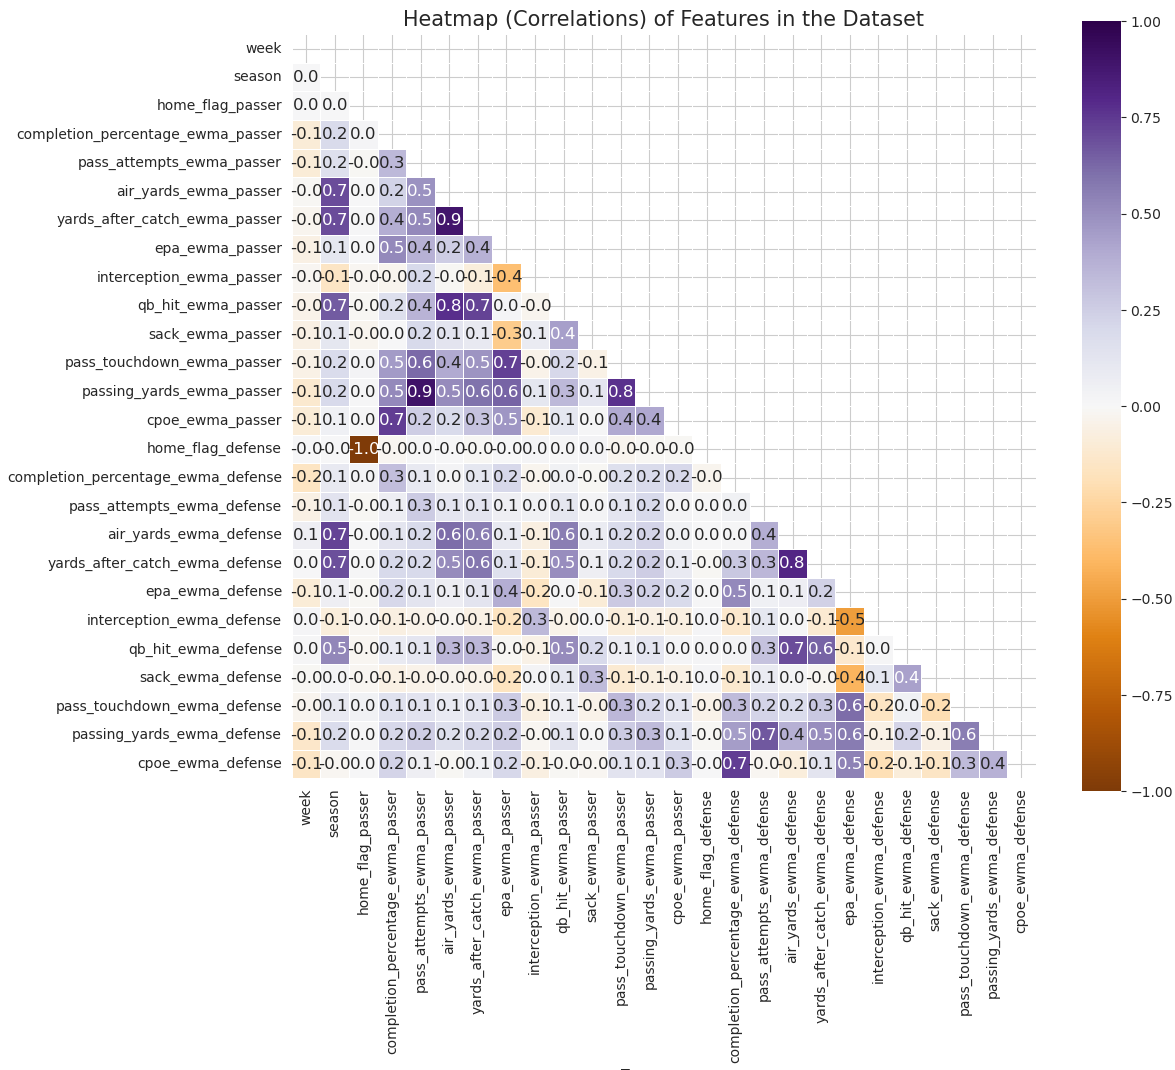

In [39]:
# Create a correlation for the dataset.
dataset_corr = df.corr()

# Drop Agent_ID from correlation dataset.
dataset_corr = dataset_corr.drop(['passing_yards'], axis=1)
dataset_corr = dataset_corr.drop(['passing_yards'], axis=0)

# Create a correlation matrix. Only bottom left corner valued.
mask = np.zeros_like(dataset_corr.round(4))
mask[np.triu_indices_from(mask)] = True

# Generate the corrleation matrix (heatmap) using Seaborn.
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(dataset_corr.round(2), mask=mask, vmax=1, center=0, vmin=-1, square=True,
                     cmap='PuOr', linewidths=.5, annot=True, annot_kws={"size": 12}, fmt='.1f')
    plt.title('Heatmap (Correlations) of Features in the Dataset', fontsize=15)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Features', fontsize=15)
plt.show()

## Modeling w/ Sci-kit Learn

maybe come back to the below cell and figure out how to transform these features into numerical values

In [94]:
# Define the target and features
target = 'passing_yards'
features = df.columns.drop(['passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'roof', 'surface'])

In [95]:
# Create machine learning df and drop NaN values
ml = df.dropna()

# Define the X and y, leave out 2022 season for testing
X = df.loc[df['season'] != 2022, features].values
y = df.loc[df['season'] != 2022, target].values

In [96]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

In [101]:
# defining parameters
params = {
    'task': 'train',
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'metric': {'l2', 'l1'},
    'verbose': -1,
    'early_stopping_rounds' : 5
}

In [105]:

# Define the parameter grid for tuning
param_grid = {
    'num_leaves': [10, 20, 30, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10, 15],
    'min_data_in_leaf': [10, 20, 30, 40],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'feature_fraction': [0.7, 0.8, 0.9],
    'lambda_l1': [0, 0.1, 0.5, 1],
    'lambda_l2': [0, 0.1, 0.5, 1],
    'objective': ['regression'],
    'metric': ['rmse']
}

# Instantiate the model
model = lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=1000, random_state=42)

# Run RandomizedSearchCV to find the best parameters
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=20, cv=3, random_state=42, verbose=1)
random_search.fit(X_train, y_train)

# Get best parameters and test RMSE
best_params = random_search.best_params_
y_pred = random_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Best Parameters: {best_params}')
print(f'RMSE: {rmse}')


NameError: name 'RandomizedSearchCV' is not defined

In [102]:
# Train the model and evaluate with testing data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [103]:
# Fit the model
gbm = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_eval])

In [104]:
# prediction
y_pred = gbm.predict(X_test)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 4609.49
RMSE: 67.89


## Making Predictions